# Warp Visuals and Measurements

Loads in galaxies and runs Neil's warp decomposition method, then plots the warp function over the galaxy to check physicality of measurements. Measurements for the warp angle and warp amplitude follow, as well as some extraneous measurements of a baryonic half-mass-radius

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import numpy as np
import h5py
from os.path import exists 
from scipy import stats
from numpy.linalg import inv
import seaborn as sns
import pandas as pd
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
import agama
from scipy.interpolate import CubicSpline

import sys
sys.path.append('/home/tnguser/python/')
from FigureRotation_util import *
from Cannon_get_principal_axes import *
from prob_plane_method import *

from astropy import constants as const
from astropy import units as u
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")
plt.style.use('mplstyle.txt')

import octantPlot

%matplotlib inline
rcParams['font.size'] = 18

from cmcrameri import cm as cmaps

sim = 'L35n2160TNG'
basePath = '/home/tnguser/sims.TNG/' + sim + '/output'

# Halos in Neil Ash's catalog
catalogue_path = '/home/tnguser/postprocessing/halocatalogues/' + sim + '.npy'
naive_halos = np.load(catalogue_path)
main_subhalos = np.load('/home/tnguser/postprocessing/halocatalogues/' + sim + '_mainSubhalos.npy') 

# CHANGE TO DESIRED FILE PATHS
anglePath = '/home/tnguser/postprocessing/angles/' + sim + '/00_15Rvir/'
spin_path = '/home/tnguser/postprocessing/angular_momentum/' + sim + '/00_15kpc/'
pattern_path =  '/home/tnguser/postprocessing/pattern_speeds/' + sim + '/00_06Rvir/'
principal_path =  '/home/tnguser/postprocessing/principal_axes/' + sim + '/00_06Rvir/'
spin_suffix = '/home/tnguser/postprocessing/angular_momentum/' + sim + '/rings_log/'
mag_path = '/home/tnguser/postprocessing/max_warp_magnitudes/'
save_name = '/home/tnguser/postprocessing/warp_magnitudes/'
angle_save_name = '/home/tnguser/postprocessing/angles/' + sim + '/warp_angles/'
snap = 99
startSnap = 75


Bad key frameon in file mplstyle.txt, line 24 ('frameon: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


In [2]:
# Taken from Neil's measure_halo_spin.ipynb
def snapshot_redshift_corr(basePath,startSnap=75):
    """
    Calls and stores z = and redshift values
    """
    redshift_space = []
    for snapshot_number in range(startSnap,100):
        header=il.groupcat.loadHeader(basePath,snapshot_number) 
        redshift_space.append(header.get('Redshift')) 
    return np.arange(startSnap,100), np.array(redshift_space) 

# Taken from Neil's measure_halo_spin.ipynb
def value(arr):
    """
    Convenience function, returns the item contained by an array,
    or an error if the array has more than one element
    """
    assert len(arr)<2
    return arr[0]


def make_unit(vec):
    """
    Convenience function, returns the unit-normalized vector
    """
    return 1/np.sqrt(np.sum(vec**2)) * vec


def getRotationAxis(snap, startStops, Raxis):
    """
    Returns the figure rotation axis at the snapshot snap
    """
    for idx, (first,second) in enumerate(startStops):
        if (snap >= first and snap < second):
            return Raxis[idx]
    return Raxis[-1]


def angleBtwn(u,v):
    """
    Returns angle between vectors u and v
    """
    u = np.array(u)
    v= np.array(v)
    u = 1/np.sqrt(np.sum(u**2))*u
    v = 1/np.sqrt(np.sum(v**2))*v
    
    return np.arccos(np.dot(u,v))

def getAngles(v):
    """
    Returns the Brigg's angles in form [polar angle, azmuthal angle]
    """
    polar_angle = angleBtwn(v,[0,0,1])
    xy_angle = np.sign(v[1])*np.arccos(v[0]/np.sqrt(v[0]**2+v[1]**2))
    return [polar_angle, xy_angle]

def getAngle(vec1, vec2):
    return np.degrees(np.arccos(np.dot(vec1, vec2)))

def z(pos,m):
    
    R = np.sqrt(pos[:,0]**2+pos[:,1]**2)
    theta = np.arctan2(pos[:,1]/R,pos[:,0]/R)
    rand_theta = np.random.uniform(0,2*np.pi,len(theta))
    
    z_arr = []
    for i in range(len(bins)-1):
        bin_inds = (R<bins[i+1])&(R>bins[i])
        
        zi = np.sum(m[bin_inds]*pos[:,2][bin_inds]*np.exp(1j*theta[bin_inds])) /\
                np.sum(m[bin_inds])
        
        z_mag = np.sqrt(zi*np.conj(zi))
        
        z_arr.append(np.real(z_mag))
        
    return 2*np.array(z_arr)
    

def xi(pos,m):
    
    R = np.sqrt(pos[:,0]**2+pos[:,1]**2)
    theta = np.arctan2(pos[:,1]/R,pos[:,0]/R)
    rand_theta = np.random.uniform(0,2*np.pi,len(theta))
    
    xi_arr = []
    for i in range(len(bins)-1):
        bin_inds = (R<bins[i+1])&(R>bins[i])
        
        xi = np.sum(m[bin_inds]*pos[:,2][bin_inds]*np.exp(1j*theta[bin_inds])) /\
                np.sum(m[bin_inds]*abs(pos[:,2][bin_inds]))
        xi_arr.append(xi)
                
    return np.array(xi_arr)

def Phi(pos,m):
    
    R = np.sqrt(pos[:,0]**2+pos[:,1]**2)
    theta = np.arctan2(pos[:,1]/R,pos[:,0]/R)
    
    Phi_arr = []
    for i in range(len(bins)-1):
        bin_inds = (R<bins[i+1])&(R>bins[i])
        
        Phi = np.arctan2(-np.sum(m[bin_inds]*pos[:,2][bin_inds]*np.sin(theta[bin_inds])), 
                     np.sum(m[bin_inds]*pos[:,2][bin_inds]*np.cos(theta[bin_inds])))
        Phi_arr.append(Phi)
        
    return np.array(Phi_arr)

def get_indices(lst, targets):
    return list(filter(lambda x: lst[x] in targets, range(len(lst))))

def find_intersection(x, y, c):
    intersections_x = []
    for i in range(len(y) - 1):
        if (y[i] - c) * (y[i+1] - c) < 0:
            # Linear interpolation
            x_intersect = x[i] + (c - y[i]) / (y[i+1] - y[i]) * (x[i+1] - x[i])
            intersections_x.append(x_intersect)
    return intersections_x

def func(x, m, b):
    return m*x + b

In [3]:
#Taken from Neil's Azimuthal_Harmonic_Warp_Expansion.ipynb
class decomposeDisk:
    
    def __init__(self,coords,mass,bins,mmax=4):
        """
        Decompose the vertical structure of the disk into an Azimuthal-Harmonic basis set.
        Inputs:
                coords: Cartesian (x,y,z) positions of the disk particles, assumed to be 
                        centered and rotated such that the central angular momentum axis 
                        lies along z
                        
                mass:   Masses of each particle
                
                bins:   annular bins in which to perform the expansion
                
                mmax:   maximum m order of the expansion. Usually higher than 1 is not needed, 
                        and may be excessively noisy currently
                        
        Outputs: 
                None
        
        """
        # Convert to cylindrical
        self.R = np.sqrt(coords[:,0]**2+coords[:,1]**2)
        self.Theta = np.arctan2(coords[:,1],coords[:,0])
        self.Z = coords[:,2]
        self.mass = mass
        self.mmax = mmax
        
        # Set up loop through bins, run decomposition on each
        self.z_m_R = []
        self.bin_centers = []
        for i in range(len(bins)-1): 
            bin_indices = (self.R>bins[i])&(self.R<bins[i+1])
            self.z_m_R.append(self.decompose(bin_indices))
            self.bin_centers.append(np.sum(mass[bin_indices]*self.R[bin_indices])/np.sum(mass[bin_indices]))
        
        # Get the mag and phase angle of coefficients
        self.z_m_R = np.array(self.z_m_R)
        self.z_m_R_mag = np.real(np.sqrt(self.z_m_R*np.conj(self.z_m_R)))
        self.z_m_R_PA = 1/np.arange(mmax+1)*np.arctan2(np.imag(self.z_m_R),np.real(self.z_m_R))
        
        # mean particle position in each bin,
        self.bin_centers = np.array(self.bin_centers)
        self.z_m_Spl = CubicSpline(self.bin_centers,self.z_m_R)
        
    def decompose(self,indices):
        """
        Performs the decomposition into the basis set coefficient weights, 
        should only be used internally by __init__
        
        Inputs:
                indices: the indices into coords and mass to be considered in the decomposition
                
        Outputs:
                z_m_arr: the coefficient weights
        
        """
        z_m_arr = []
        for m in range(0,self.mmax+1,1):
            z_m = np.sum(self.mass[indices]*self.Z[indices]*np.exp(1j*m*self.Theta[indices])) /\
                    np.sum(self.mass[indices])
            if m != 0: z_m *= 2
            z_m_arr.append(z_m)
        return np.array(z_m_arr)        
        
    def reconstruct_disk(self,pos,m_inds=None):
        """
        Recover the model z-height above/below the nominal disk plane for selected m-modes
        Inputs: 
                pos:      array-like grid of points to return z-height along
                m_inds:   array-like or int, m-modes to use in model reconstruction
            
        Outputs:
                z_recov:  array of same shape as pos, the model z-value at pos
        """
        m_arr = np.arange(self.mmax+1)
        
        # Convert to cylindrical 
        R = np.sqrt(pos[:,0]**2+pos[:,1]**2)
        Theta = np.arctan2(pos[:,1],pos[:,0])
        
        # Get the interpolated coefficients
        z_m = self.z_m_Spl(R)
        
        # Recover phase angle and magnitude of coefficients
        z_phi = 1/m_arr * np.arctan2(np.imag(z_m),np.real(z_m))
        z_mag = np.real(np.sqrt(z_m*np.conj(z_m)))
        
        # Reconstruct z-profile, sum contribution from each m
        if m_inds is None:
            m_inds = m_arr
            
        z_recov_m = np.array([z_mag[:,m]*np.cos(m_arr[m]*(Theta-z_phi[:,m])) for m in m_arr])
        return np.nansum(z_recov_m[m_inds,:],axis=0)

## Warp Visualization

Some modifications here to try to see if there's any fly-by interactions happening

In [4]:
final_diskyIDs = np.load('/home/tnguser/postprocessing/circularity_study/final_diskyIDs.npy')

In [5]:
subfindID = (final_diskyIDs)[8]
GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

snapArr,zArr = snapshot_redshift_corr(basePath)
haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                     fields=['SubhaloGrNr','SnapNum','Group_R_Crit200','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'], 
                                     onlyMPB=True)

haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
subfindID = haloTree['SubhaloNumber']
Rvirial   = haloTree['Group_R_Crit200']
subhaloPos = haloTree['SubhaloPos']
halfmassrad = haloTree['SubhaloHalfmassRadType']

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


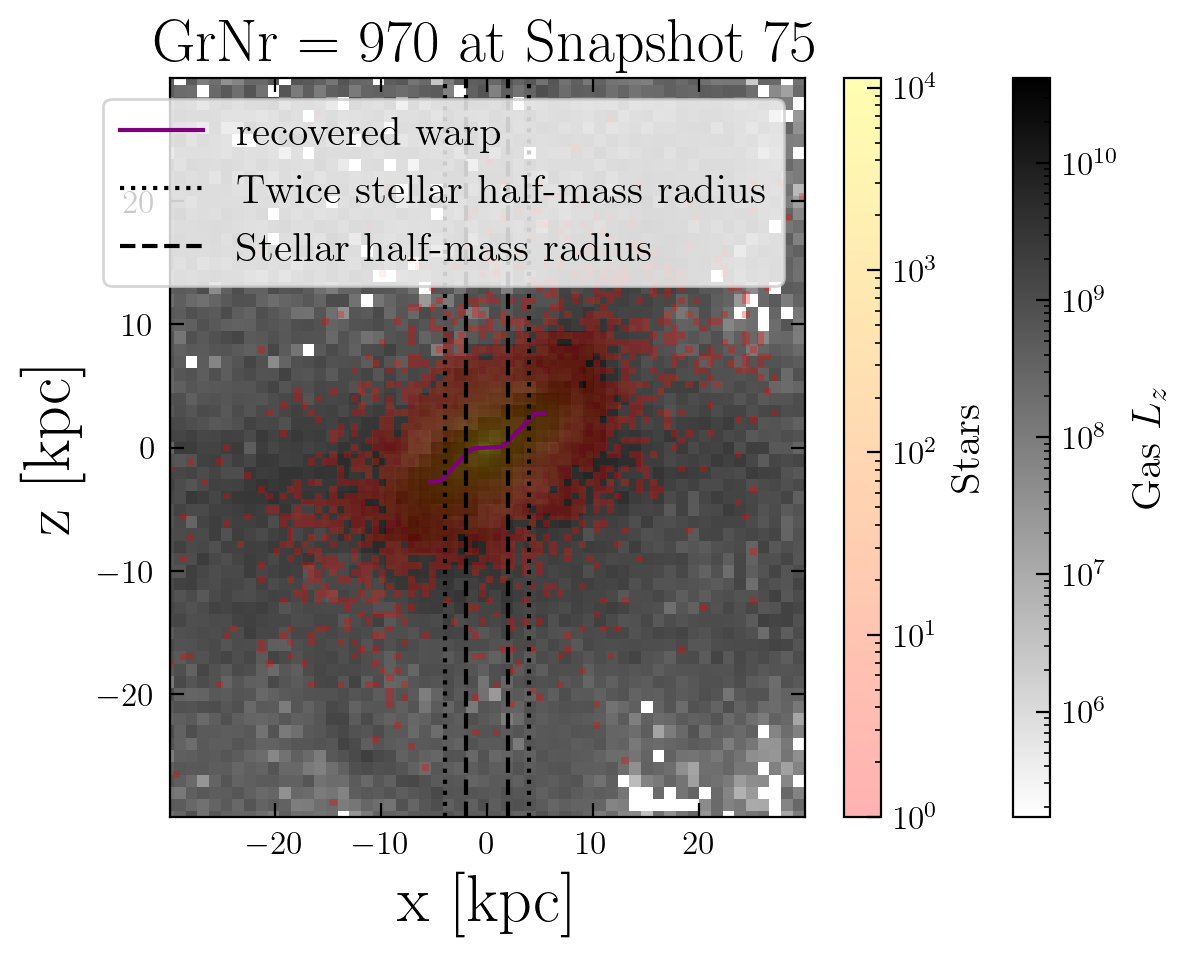

In [7]:
for snap in tqdm(range(75,76)):
    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    Rvirial_i    = value(Rvirial[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    dmPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')

    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    gasVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Velocities')
    dmVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Velocities')

    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

        # following Neil's method, but only using stars (not gas or DM)
    if (type(starPos) is not dict):
        particleCoords_bar  = starPos
        particleVels_bar    = starVel
        particleMass_bar    = starMass * 1e10
    else:
            # no stars in the halo
        print("ERROR: no stars in halo.")
        particleCoords_bar  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_bar    = np.array([[np.nan,np.nan,np.nan]])
        particleMass_bar    = np.array([np.nan])

    if (type(gasPos) is not dict):
        particleCoords_gas  = gasPos
        particleVels_gas    = gasVel
        particleMass_gas    = gasMass * 1e10

    else:
            # no stars in the halo
        print("ERROR: no gas in halo.")
        particleCoords_gas  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_gas    = np.array([[np.nan,np.nan,np.nan]])
        particleMass_gas    = np.array([np.nan])

    if (type(dmPos) is not dict):
        particleCoords_dm  = dmPos
        particleVels_dm   = dmVel

    else:
            # no stars in the halo
        print("ERROR: no dark matter in halo.")
        particleCoords_dm  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_dm    = np.array([[np.nan,np.nan,np.nan]])

        ########################################################################
        # check that the halo is not crossing the box boundary, correct if it is
        # condition is whether it is within 2 virial radii
    passUpperBound = subhaloPos_i + 2*Rvirial_i >= 35000
    passLowerBound = subhaloPos_i - 2*Rvirial_i <= 0

    if any(passUpperBound):
            # shift the particles
        particleCoords_bar[:,passUpperBound] = particleCoords_bar[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_bar[:,passUpperBound]<0)[0]
        particleCoords_bar[ind_bar,passUpperBound] = particleCoords_bar[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_bar[:,passLowerBound] = particleCoords_bar[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_bar[:,passLowerBound]>35000)[0]
        particleCoords_bar[ind_bar,passLowerBound] = particleCoords_bar[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
        # find relative velocities - shouldn't have done this, instead use the spin by TNG (includes DM)
    paricleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a) # km/s

    if any(passUpperBound):
            # shift the particles
        particleCoords_gas[:,passUpperBound] = particleCoords_gas[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_gas[:,passUpperBound]<0)[0]
        particleCoords_gas[ind_bar,passUpperBound] = particleCoords_gas[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_gas[:,passLowerBound] = particleCoords_gas[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_gas[:,passLowerBound]>35000)[0]
        particleCoords_gas[ind_bar,passLowerBound] = particleCoords_gas[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a
    particleVels_gas = (particleVels_gas - np.mean(particleVels_gas,axis=0)) * np.sqrt(a) # km/s

    if any(passUpperBound):
            # shift the particles
        particleCoords_dm[:,passUpperBound] = particleCoords_dm[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_dm[:,passUpperBound]<0)[0]
        particleCoords_dm[ind_bar,passUpperBound] = particleCoords_dm[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_dm[:,passLowerBound] = particleCoords_dm[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_dm[:,passLowerBound]>35000)[0]
        particleCoords_dm[ind_bar,passLowerBound] = particleCoords_dm[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_dm = (particleCoords_dm - subhaloPos_i)*a
    particleVels_dm = (particleVels_dm - np.mean(particleVels_dm,axis=0)) * np.sqrt(a) # km/s

    # Rotate into plane of inner disk
    r = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    in_half = r<=halfmassrad_i

    L_parts = particleMass_bar.reshape(-1,1) * np.cross(particleCoords_bar,
                                                          paricleVels_bar)
    L_spec_half = (np.sum(L_parts[in_half],axis=0) / np.sum(particleMass_bar[in_half]).reshape(-1,1)).reshape(3)

    e3 = L_spec_half / np.sqrt(np.sum(L_spec_half**2))
    e1 = np.cross(np.array([0,1,0]),e3)
    e1 = e1 / np.sqrt(np.sum(e1**2))
    e2 = np.cross(e3,e1)

    Rmat = np.array([e1,e2,e3]).T

    # Rotate
    particleCoords_bar = Rmat.T.dot(particleCoords_bar.T).T
    particleVels_bar = Rmat.T.dot(particleVels_bar.T).T

    particleCoords_gas = Rmat.T.dot(particleCoords_gas.T).T
    particleVels_gas = Rmat.T.dot(particleVels_gas.T).T

    particleCoords_dm = Rmat.T.dot(particleCoords_dm.T).T
    particleVels_dm = Rmat.T.dot(particleVels_dm.T).T

    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))
    
    starsInBounds = np.where((r_bar>0)&(r_bar<=15*halfmassrad_i))[0]        
    gasInBounds = np.where((r_gas>0)&(r_gas<=15*halfmassrad_i))[0]        
    L_gas = particleMass_gas.reshape(-1,1) * np.cross(particleCoords_gas,particleVels_gas)
    
    s_rad_3d = np.linalg.norm(particleCoords_bar,axis=1)
    s_bins_sequence = np.linspace(0,np.max(s_rad_3d),500)
    s_indices = np.digitize(s_rad_3d,s_bins_sequence)

    g_rad_3d = np.linalg.norm(particleCoords_gas,axis=1)
    g_bins_sequence = np.linspace(0,np.max(g_rad_3d),500)
    g_indices = np.digitize(g_rad_3d,g_bins_sequence)

    s_total_mass_array = []
    for i in range(len(s_bins_sequence)):
        s_total_mass_array.append(np.sum(particleMass_bar[s_indices==i]))
    s_cumulative_mass_array = np.cumsum(s_total_mass_array)

    g_total_mass_array = []
    for i in range(len(g_bins_sequence)):
        g_total_mass_array.append(np.sum(particleMass_gas[g_indices==i]))
    g_cumulative_mass_array = np.cumsum(g_total_mass_array)

    bins = np.logspace(0,np.log10(3*halfmassrad_i),10)
    mmax = 3
    # Decompose the disk 
    warpModel = decomposeDisk(particleCoords_bar,
                          particleMass_bar,bins,mmax=mmax)

    recover_wa = np.median(warpModel.z_m_R_PA[:,1])
    Rz = np.array([[np.cos(recover_wa),-np.sin(recover_wa),0],
                   [np.sin(recover_wa),np.cos(recover_wa),0],
                   [0,0,1]])

    plt.figure()
    plt.title(f'GrNr = {GrNr} at Snapshot {snap}')
    pos_warp_rot = Rz.dot(particleCoords_bar.T).T
    pos_gas_rot = Rz.dot(particleCoords_gas.T).T

    plt.hist2d(pos_gas_rot[:,0], pos_gas_rot[:,2], bins=(160,160), norm=mpl.colors.LogNorm(),cmap=plt.cm.binary, weights = L_gas[:,2], label='Gas L')
    plt.colorbar(label='Gas $L_z$')
    plt.hist2d(pos_warp_rot[:,0], pos_warp_rot[:,2], bins=(160,160), norm=mpl.colors.LogNorm(),cmap=plt.cm.autumn,label='stars',alpha=0.3)
    plt.colorbar(label='Stars')
    plt.xlabel("x [kpc]",fontsize=24)
    plt.ylabel("z [kpc]",fontsize=24)
    plt.xlim(-15*halfmassrad_i,15*halfmassrad_i)
    plt.ylim(-15*halfmassrad_i,15*halfmassrad_i)

    bin_centers_reflected = np.concatenate((np.flipud(-warpModel.bin_centers),warpModel.bin_centers))
    z_R_reflected = np.concatenate((np.flipud(-warpModel.z_m_R_mag[:,1]),warpModel.z_m_R_mag[:,1]))

    plt.plot((bin_centers_reflected),z_R_reflected,color='purple',label='recovered warp')

    plt.axvline(2*halfmassrad_i,linestyle=':',c='black',label='Twice stellar half-mass radius')
    plt.axvline(-2*halfmassrad_i,linestyle=':',c='black')
    plt.axvline(halfmassrad_i,linestyle='--',c='black',label='Stellar half-mass radius')
    plt.axvline(-halfmassrad_i,linestyle='--',c='black')

    plt.legend()

100%|██████████| 1/1 [00:10<00:00, 10.27s/it]


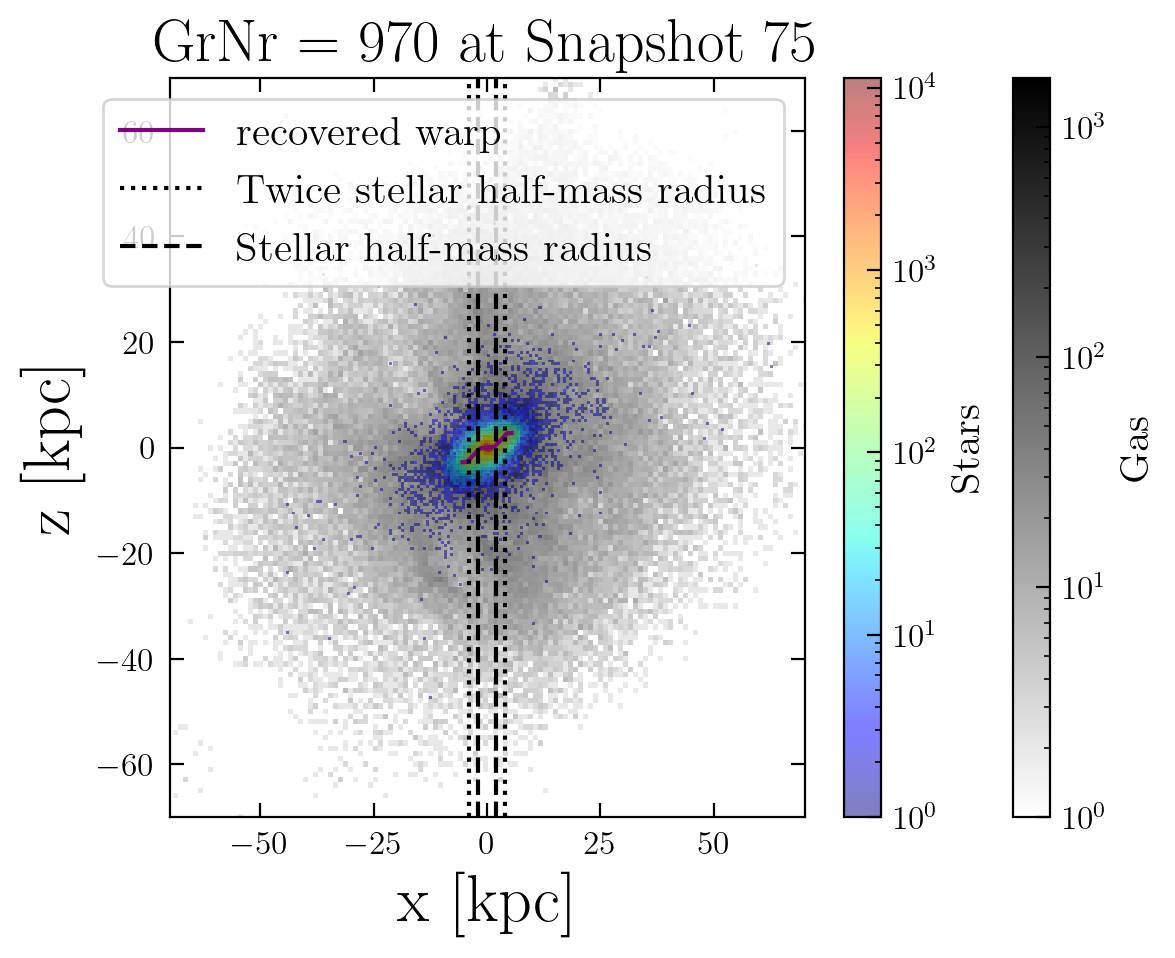

In [8]:
subfindID = (final_diskyIDs)[8]
GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

snapArr,zArr = snapshot_redshift_corr(basePath)
haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                     fields=['SubhaloGrNr','SnapNum','Group_R_Crit200','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'], 
                                     onlyMPB=True)
stars = il.snapshot.loadHalo(basePath,99,GrNr,'stars')

haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
subfindID = haloTree['SubhaloNumber']
Rvirial   = haloTree['Group_R_Crit200']
subhaloPos = haloTree['SubhaloPos']
halfmassrad = haloTree['SubhaloHalfmassRadType']

for snap in tqdm(range(75,76)):
    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    Rvirial_i    = value(Rvirial[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    dmPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')

    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    gasVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Velocities')
    dmVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Velocities')

    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

        # following Neil's method, but only using stars (not gas or DM)
    if (type(starPos) is not dict):
        particleCoords_bar  = starPos
        particleVels_bar    = starVel
        particleMass_bar    = starMass * 1e10
    else:
            # no stars in the halo
        print("ERROR: no stars in halo.")
        particleCoords_bar  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_bar    = np.array([[np.nan,np.nan,np.nan]])
        particleMass_bar    = np.array([np.nan])

    if (type(gasPos) is not dict):
        particleCoords_gas  = gasPos
        particleVels_gas    = gasVel
        particleMass_gas    = gasMass * 1e10

    else:
            # no stars in the halo
        print("ERROR: no gas in halo.")
        particleCoords_gas  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_gas    = np.array([[np.nan,np.nan,np.nan]])
        particleMass_gas    = np.array([np.nan])

    if (type(dmPos) is not dict):
        particleCoords_dm  = dmPos
        particleVels_dm   = dmVel

    else:
            # no stars in the halo
        print("ERROR: no dark matter in halo.")
        particleCoords_dm  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_dm    = np.array([[np.nan,np.nan,np.nan]])

        ########################################################################
        # check that the halo is not crossing the box boundary, correct if it is
        # condition is whether it is within 2 virial radii
    passUpperBound = subhaloPos_i + 2*Rvirial_i >= 35000
    passLowerBound = subhaloPos_i - 2*Rvirial_i <= 0

    if any(passUpperBound):
            # shift the particles
        particleCoords_bar[:,passUpperBound] = particleCoords_bar[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_bar[:,passUpperBound]<0)[0]
        particleCoords_bar[ind_bar,passUpperBound] = particleCoords_bar[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_bar[:,passLowerBound] = particleCoords_bar[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_bar[:,passLowerBound]>35000)[0]
        particleCoords_bar[ind_bar,passLowerBound] = particleCoords_bar[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
        # find relative velocities - shouldn't have done this, instead use the spin by TNG (includes DM)
    paricleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a) # km/s

    if any(passUpperBound):
            # shift the particles
        particleCoords_gas[:,passUpperBound] = particleCoords_gas[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_gas[:,passUpperBound]<0)[0]
        particleCoords_gas[ind_bar,passUpperBound] = particleCoords_gas[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_gas[:,passLowerBound] = particleCoords_gas[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_gas[:,passLowerBound]>35000)[0]
        particleCoords_gas[ind_bar,passLowerBound] = particleCoords_gas[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a
    particleVels_gas = (particleVels_gas - np.mean(particleVels_gas,axis=0)) * np.sqrt(a) # km/s

    if any(passUpperBound):
            # shift the particles
        particleCoords_dm[:,passUpperBound] = particleCoords_dm[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_dm[:,passUpperBound]<0)[0]
        particleCoords_dm[ind_bar,passUpperBound] = particleCoords_dm[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_dm[:,passLowerBound] = particleCoords_dm[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_dm[:,passLowerBound]>35000)[0]
        particleCoords_dm[ind_bar,passLowerBound] = particleCoords_dm[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_dm = (particleCoords_dm - subhaloPos_i)*a
    particleVels_dm = (particleVels_dm - np.mean(particleVels_dm,axis=0)) * np.sqrt(a) # km/s

    # Rotate into plane of inner disk
    r = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    in_half = r<=halfmassrad_i

    L_parts = particleMass_bar.reshape(-1,1) * np.cross(particleCoords_bar,
                                                          paricleVels_bar)
    L_spec_half = (np.sum(L_parts[in_half],axis=0) / np.sum(particleMass_bar[in_half]).reshape(-1,1)).reshape(3)


    e3 = L_spec_half / np.sqrt(np.sum(L_spec_half**2))
    e1 = np.cross(np.array([0,1,0]),e3)
    e1 = e1 / np.sqrt(np.sum(e1**2))
    e2 = np.cross(e3,e1)

    Rmat = np.array([e1,e2,e3]).T

    # Rotate
    particleCoords_bar = Rmat.T.dot(particleCoords_bar.T).T
    particleVels_bar = Rmat.T.dot(particleVels_bar.T).T

    particleCoords_gas = Rmat.T.dot(particleCoords_gas.T).T
    particleVels_gas = Rmat.T.dot(particleVels_gas.T).T

    particleCoords_dm = Rmat.T.dot(particleCoords_dm.T).T
    particleVels_dm = Rmat.T.dot(particleVels_dm.T).T

    r_bar = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    r_gas = np.sqrt(np.sum(particleCoords_gas**2,axis=1))

    s_rad_3d = np.linalg.norm(particleCoords_bar,axis=1)
    s_bins_sequence = np.linspace(0,np.max(s_rad_3d),500)
    s_indices = np.digitize(s_rad_3d,s_bins_sequence)

    g_rad_3d = np.linalg.norm(particleCoords_gas,axis=1)
    g_bins_sequence = np.linspace(0,np.max(g_rad_3d),500)
    g_indices = np.digitize(g_rad_3d,g_bins_sequence)

    s_total_mass_array = []
    for i in range(len(s_bins_sequence)):
        s_total_mass_array.append(np.sum(particleMass_bar[s_indices==i]))
    s_cumulative_mass_array = np.cumsum(s_total_mass_array)

    g_total_mass_array = []
    for i in range(len(g_bins_sequence)):
        g_total_mass_array.append(np.sum(particleMass_gas[g_indices==i]))
    g_cumulative_mass_array = np.cumsum(g_total_mass_array)

    bins = np.logspace(0,np.log10(3*halfmassrad_i),10)
    mmax = 3
    # Decompose the disk 
    warpModel = decomposeDisk(particleCoords_bar,
                          particleMass_bar,bins,mmax=mmax)

    recover_wa = np.median(warpModel.z_m_R_PA[:,1])
    Rz = np.array([[np.cos(recover_wa),-np.sin(recover_wa),0],
                   [np.sin(recover_wa),np.cos(recover_wa),0],
                   [0,0,1]])

    plt.figure()
    plt.title(f'GrNr = {GrNr} at Snapshot {snap}')
    pos_warp_rot = Rz.dot(particleCoords_bar.T).T
    pos_gas_rot = Rz.dot(particleCoords_gas.T).T

    plt.hist2d(pos_gas_rot[:,0], pos_gas_rot[:,2], bins=(160,160), norm=mpl.colors.LogNorm(),cmap=plt.cm.binary,label='gas')
    plt.colorbar(label='Gas')
    plt.hist2d(pos_warp_rot[:,0], pos_warp_rot[:,2], bins=(160,160), norm=mpl.colors.LogNorm(),cmap=plt.cm.jet,label='stars',alpha=0.5)
    plt.colorbar(label='Stars')
    plt.xlabel("x [kpc]",fontsize=24)
    plt.ylabel("z [kpc]",fontsize=24)
    plt.xlim(-70,70)
    plt.ylim(-70,70)

    bin_centers_reflected = np.concatenate((np.flipud(-warpModel.bin_centers),warpModel.bin_centers))
    z_R_reflected = np.concatenate((np.flipud(-warpModel.z_m_R_mag[:,1]),warpModel.z_m_R_mag[:,1]))

    plt.plot((bin_centers_reflected),z_R_reflected,color='purple',label='recovered warp')

    plt.axvline(2*halfmassrad_i,linestyle=':',c='black',label='Twice stellar half-mass radius')
    plt.axvline(-2*halfmassrad_i,linestyle=':',c='black')
    plt.axvline(halfmassrad_i,linestyle='--',c='black',label='Stellar half-mass radius')
    plt.axvline(-halfmassrad_i,linestyle='--',c='black')

    plt.legend()

## Movie Maker

In [7]:
import imageio

In [8]:
subfindID = final_diskyIDs[8]
GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

snapArr,zArr = snapshot_redshift_corr(basePath)
haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                     fields=['SubhaloGrNr','SnapNum','Group_R_Crit200','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'], 
                                     onlyMPB=True)

haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
subfindID = haloTree['SubhaloNumber']
Rvirial   = haloTree['Group_R_Crit200']
subhaloPos = haloTree['SubhaloPos']
halfmassrad = haloTree['SubhaloHalfmassRadType']

for snap in tqdm(range(75,100)):
    
    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    Rvirial_i    = value(Rvirial[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a
    
    allStarPos = il.snapshot.loadHalo(basePath,snap,GrNr,'stars',fields='Coordinates')
    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
    dmPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')

    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    gasVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Velocities')
    dmVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Velocities')

    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 
    gasMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Masses') 

        # following Neil's method, but only using stars (not gas or DM)
    if (type(starPos) is not dict):
        particleCoords_bar  = starPos
        particleVels_bar    = starVel
        particleMass_bar    = starMass * 1e10
    else:
            # no stars in the halo
        print("ERROR: no stars in halo.")
        particleCoords_bar  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_bar    = np.array([[np.nan,np.nan,np.nan]])
        particleMass_bar    = np.array([np.nan])

    if (type(gasPos) is not dict):
        particleCoords_gas  = gasPos
        particleVels_gas    = gasVel
        particleMass_gas    = gasMass * 1e10

    else:
            # no stars in the halo
        print("ERROR: no gas in halo.")
        particleCoords_gas  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_gas    = np.array([[np.nan,np.nan,np.nan]])
        particleMass_gas    = np.array([np.nan])

    if (type(dmPos) is not dict):
        particleCoords_dm  = dmPos
        particleVels_dm   = dmVel

    else:
            # no stars in the halo
        print("ERROR: no dark matter in halo.")
        particleCoords_dm  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_dm    = np.array([[np.nan,np.nan,np.nan]])

        ########################################################################
        # check that the halo is not crossing the box boundary, correct if it is
        # condition is whether it is within 2 virial radii
    passUpperBound = subhaloPos_i + 2*Rvirial_i >= 35000
    passLowerBound = subhaloPos_i - 2*Rvirial_i <= 0

    if any(passUpperBound):
            # shift the particles
        particleCoords_bar[:,passUpperBound] = particleCoords_bar[:,passUpperBound] - 35000/2
        particleCoords_all[:,passUpperBound] = particleCoords_all[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_bar[:,passUpperBound]<0)[0]
        particleCoords_bar[ind_bar,passUpperBound] = particleCoords_bar[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_bar[:,passLowerBound] = particleCoords_bar[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_bar[:,passLowerBound]>35000)[0]
        particleCoords_bar[ind_bar,passLowerBound] = particleCoords_bar[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
    allStarPos = (allStarPos - subhaloPos_i)*a
        # find relative velocities - shouldn't have done this, instead use the spin by TNG (includes DM)
    paricleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a) # km/s

    if any(passUpperBound):
            # shift the particles
        particleCoords_gas[:,passUpperBound] = particleCoords_gas[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_gas[:,passUpperBound]<0)[0]
        particleCoords_gas[ind_bar,passUpperBound] = particleCoords_gas[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_gas[:,passLowerBound] = particleCoords_gas[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_gas[:,passLowerBound]>35000)[0]
        particleCoords_gas[ind_bar,passLowerBound] = particleCoords_gas[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a
    particleVels_gas = (particleVels_gas - np.mean(particleVels_gas,axis=0)) * np.sqrt(a) # km/s

    if any(passUpperBound):
            # shift the particles
        particleCoords_dm[:,passUpperBound] = particleCoords_dm[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_dm[:,passUpperBound]<0)[0]
        particleCoords_dm[ind_bar,passUpperBound] = particleCoords_dm[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_dm[:,passLowerBound] = particleCoords_dm[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_dm[:,passLowerBound]>35000)[0]
        particleCoords_dm[ind_bar,passLowerBound] = particleCoords_dm[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_dm = (particleCoords_dm - subhaloPos_i)*a
    particleVels_dm = (particleVels_dm - np.mean(particleVels_dm,axis=0)) * np.sqrt(a) # km/s

    # Rotate into plane of inner disk
    r = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    in_half = r<=halfmassrad_i

    L_parts = particleMass_bar.reshape(-1,1) * np.cross(particleCoords_bar,
                                                          paricleVels_bar)
    L_spec_half = (np.sum(L_parts[in_half],axis=0) / np.sum(particleMass_bar[in_half]).reshape(-1,1)).reshape(3)


    e3 = L_spec_half / np.sqrt(np.sum(L_spec_half**2))
    e1 = np.cross(np.array([0,1,0]),e3)
    e1 = e1 / np.sqrt(np.sum(e1**2))
    e2 = np.cross(e3,e1)

    Rmat = np.array([e1,e2,e3]).T

    # Rotate
    allStarPos = Rmat.T.dot(allStarPos.T).T
    
    particleCoords_bar = Rmat.T.dot(particleCoords_bar.T).T
    particleVels_bar = Rmat.T.dot(particleVels_bar.T).T

    particleCoords_gas = Rmat.T.dot(particleCoords_gas.T).T
    particleVels_gas = Rmat.T.dot(particleVels_gas.T).T

    particleCoords_dm = Rmat.T.dot(particleCoords_dm.T).T
    particleVels_dm = Rmat.T.dot(particleVels_dm.T).T

    bins = np.logspace(0,np.log10(3*halfmassrad_i),10)
    mmax = 3
    # Decompose the disk 
    warpModel = decomposeDisk(particleCoords_bar,particleMass_bar,bins,mmax=mmax)
    recover_wa = np.median(warpModel.z_m_R_PA[:,1])
    Rz = np.array([[np.cos(recover_wa),-np.sin(recover_wa),0],
                   [np.sin(recover_wa),np.cos(recover_wa),0],
                   [0,0,1]])

    plt.figure()
    plt.title(f'GrNr = {GrNr}')
    allStarPos = Rz.dot(allStarPos.T).T
    pos_warp_rot = Rz.dot(particleCoords_bar.T).T
    bin_centers_reflected = np.concatenate((np.flipud(-warpModel.bin_centers),warpModel.bin_centers))
    z_R_reflected = np.concatenate((np.flipud(-warpModel.z_m_R_mag[:,1]),warpModel.z_m_R_mag[:,1]))

    plt.scatter(allStarPos[:,0], allStarPos[:,2], c='orange', s=1)
    plt.scatter(pos_warp_rot[:,0], pos_warp_rot[:,2], c='orange', label='stars',s=1)
    plt.xlabel("x [kpc]",fontsize=24)
    plt.ylabel("z [kpc]",fontsize=24)
    plt.xlim(-27000,27000)
    plt.ylim(-6500,30000)
    
    plt.savefig(f'{GrNr}_Snap_{snap}.png')
    plt.close()
    
with imageio.get_writer(f'{GrNr}.gif', mode='i') as writer:
    for i in range(75, 100):
        image = imageio.imread(f'Snap_{i}.png')
        writer.append_data(image)

100%|██████████| 25/25 [01:06<00:00,  2.65s/it]


## Warp Calculation

In [ ]:
for subfindID in tqdm(np.sort(final_diskyIDs)):
    warp_z_angles = []
    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)
    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                         fields=['SubhaloGrNr','SnapNum','Group_R_Crit200','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'], 
                                         onlyMPB=True)

    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    Rvirial   = haloTree['Group_R_Crit200']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']

    for snap in (range(75,100)):
        GrNr_i       = value(haloInd[snap == mpb_snapArr])
        subfindID_i  = value(subfindID[snap == mpb_snapArr])
        Rvirial_i    = value(Rvirial[snap == mpb_snapArr])
        subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
        a = 1/(1+value(zArr[snap==snapArr]))
        halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

        starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
        gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
        dmPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')

        starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
        gasVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Velocities')
        dmVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Velocities')

        starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 

            # following Neil's method, but only using stars (not gas or DM)
        if (type(starPos) is not dict):
            particleCoords_bar  = starPos
            particleVels_bar    = starVel
            particleMass_bar    = starMass * 1e10
        else:
                # no stars in the halo
            print("ERROR: no stars in halo.")
            particleCoords_bar  = np.array([[np.nan,np.nan,np.nan]])
            particleVels_bar    = np.array([[np.nan,np.nan,np.nan]])
            particleMass_bar    = np.array([np.nan])

        if (type(gasPos) is not dict):
            particleCoords_gas  = gasPos
            particleVels_gas    = gasVel

        else:
                # no stars in the halo
            print("ERROR: no gas in halo.")
            particleCoords_gas  = np.array([[np.nan,np.nan,np.nan]])
            particleVels_gas    = np.array([[np.nan,np.nan,np.nan]])

        if (type(gasPos) is not dict):
            particleCoords_dm  = dmPos
            particleVels_dm   = dmVel

        else:
                # no stars in the halo
            print("ERROR: no dark matter in halo.")
            particleCoords_dm  = np.array([[np.nan,np.nan,np.nan]])
            particleVels_dm    = np.array([[np.nan,np.nan,np.nan]])

            ########################################################################
            # check that the halo is not crossing the box boundary, correct if it is
            # condition is whether it is within 2 virial radii
        passUpperBound = subhaloPos_i + 2*Rvirial_i >= 35000
        passLowerBound = subhaloPos_i - 2*Rvirial_i <= 0

        if any(passUpperBound):
                # shift the particles
            particleCoords_bar[:,passUpperBound] = particleCoords_bar[:,passUpperBound] - 35000/2
            subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
                #reinforce boundary condition
            ind_bar = np.where(particleCoords_bar[:,passUpperBound]<0)[0]
            particleCoords_bar[ind_bar,passUpperBound] = particleCoords_bar[ind_bar,passUpperBound] + 35000

        if any(passLowerBound):
            particleCoords_bar[:,passLowerBound] = particleCoords_bar[:,passLowerBound] + 35000/2 
            subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

            ind_bar = np.where(particleCoords_bar[:,passLowerBound]>35000)[0]
            particleCoords_bar[ind_bar,passLowerBound] = particleCoords_bar[ind_bar,passLowerBound] - 35000
            ########################################################################

            # center coords on subhalo pos
        particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
            # find relative velocities - shouldn't have done this, instead use the spin by TNG (includes DM)
        paricleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a) # km/s

        if any(passUpperBound):
                # shift the particles
            particleCoords_gas[:,passUpperBound] = particleCoords_gas[:,passUpperBound] - 35000/2
            subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
                #reinforce boundary condition
            ind_bar = np.where(particleCoords_gas[:,passUpperBound]<0)[0]
            particleCoords_gas[ind_bar,passUpperBound] = particleCoords_gas[ind_bar,passUpperBound] + 35000

        if any(passLowerBound):
            particleCoords_gas[:,passLowerBound] = particleCoords_gas[:,passLowerBound] + 35000/2 
            subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

            ind_bar = np.where(particleCoords_gas[:,passLowerBound]>35000)[0]
            particleCoords_gas[ind_bar,passLowerBound] = particleCoords_gas[ind_bar,passLowerBound] - 35000
            ########################################################################

            # center coords on subhalo pos
        particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a
        particleVels_gas = (particleVels_gas - np.mean(particleVels_gas,axis=0)) * np.sqrt(a) # km/s

        if any(passUpperBound):
                # shift the particles
            particleCoords_dm[:,passUpperBound] = particleCoords_dm[:,passUpperBound] - 35000/2
            subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
                #reinforce boundary condition
            ind_bar = np.where(particleCoords_dm[:,passUpperBound]<0)[0]
            particleCoords_dm[ind_bar,passUpperBound] = particleCoords_dm[ind_bar,passUpperBound] + 35000

        if any(passLowerBound):
            particleCoords_dm[:,passLowerBound] = particleCoords_dm[:,passLowerBound] + 35000/2 
            subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

            ind_bar = np.where(particleCoords_dm[:,passLowerBound]>35000)[0]
            particleCoords_dm[ind_bar,passLowerBound] = particleCoords_dm[ind_bar,passLowerBound] - 35000
            ########################################################################

            # center coords on subhalo pos
        particleCoords_dm = (particleCoords_dm - subhaloPos_i)*a
        particleVels_dm = (particleVels_dm - np.mean(particleVels_dm,axis=0)) * np.sqrt(a) # km/s

        # Rotate into plane of inner disk
        r = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
        in_half = r<=halfmassrad_i

        L_parts = particleMass_bar.reshape(-1,1) * np.cross(particleCoords_bar,
                                                              paricleVels_bar)
        L_spec_half = (np.sum(L_parts[in_half],axis=0) / np.sum(particleMass_bar[in_half]).reshape(-1,1)).reshape(3)


        e3 = L_spec_half / np.sqrt(np.sum(L_spec_half**2))
        e1 = np.cross(np.array([0,1,0]),e3)
        e1 = e1 / np.sqrt(np.sum(e1**2))
        e2 = np.cross(e3,e1)

        Rmat = np.array([e1,e2,e3]).T

        # Rotate
        particleCoords_bar = Rmat.T.dot(particleCoords_bar.T).T
        particleVels_bar = Rmat.T.dot(particleVels_bar.T).T

        particleCoords_gas = Rmat.T.dot(particleCoords_gas.T).T
        particleVels_gas = Rmat.T.dot(particleVels_gas.T).T

        particleCoords_dm = Rmat.T.dot(particleCoords_dm.T).T
        particleVels_dm = Rmat.T.dot(particleVels_dm.T).T

        bins = np.logspace(np.log10(halfmassrad_i),np.log10(2*halfmassrad_i),10)
        mmax = 3
        # Decompose the disk 
        warpModel = decomposeDisk(particleCoords_bar,
                              particleMass_bar,bins,mmax=mmax)

        popt, pcov = curve_fit(func, warpModel.bin_centers, warpModel.z_m_R_mag[:,1])
        warp_z_angles.append(np.abs(np.degrees(np.arctan2(func(warpModel.bin_centers, *popt)[-1],warpModel.bin_centers[-1]))))
    temp = angle_save_name+'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,75)
    np.save(temp,warp_z_angles,allow_pickle=True)

In [ ]:
for subfindID in tqdm(np.sort(final_diskyIDs)):

    GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

    snapArr,zArr = snapshot_redshift_corr(basePath)

    haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                         fields=['SubhaloGrNr','SnapNum','Group_R_Crit200','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'], 
                                         onlyMPB=True)

    haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
    subfindID = haloTree['SubhaloNumber']
    Rvirial   = haloTree['Group_R_Crit200']
    subhaloPos = haloTree['SubhaloPos']
    halfmassrad = haloTree['SubhaloHalfmassRadType']
    
    all_mags = []

    for snap in (range(75,100)):
        GrNr_i       = value(haloInd[snap == mpb_snapArr])
        subfindID_i  = value(subfindID[snap == mpb_snapArr])
        Rvirial_i    = value(Rvirial[snap == mpb_snapArr])
        subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
        a = 1/(1+value(zArr[snap==snapArr]))
        halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

        starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
        gasPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Coordinates')
        dmPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Coordinates')

        starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
        gasVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,0,fields='Velocities')
        dmVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,1,fields='Velocities')

        starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 

            # following Neil's method, but only using stars (not gas or DM)
        if (type(starPos) is not dict):
            particleCoords_bar  = starPos
            particleVels_bar    = starVel
            particleMass_bar    = starMass * 1e10
        else:
                # no stars in the halo
            print("ERROR: no stars in halo.")
            particleCoords_bar  = np.array([[np.nan,np.nan,np.nan]])
            particleVels_bar    = np.array([[np.nan,np.nan,np.nan]])
            particleMass_bar    = np.array([np.nan])

        if (type(gasPos) is not dict):
            particleCoords_gas  = gasPos
            particleVels_gas    = gasVel

        else:
                # no stars in the halo
            print("ERROR: no gas in halo.")
            particleCoords_gas  = np.array([[np.nan,np.nan,np.nan]])
            particleVels_gas    = np.array([[np.nan,np.nan,np.nan]])

        if (type(gasPos) is not dict):
            particleCoords_dm  = dmPos
            particleVels_dm   = dmVel

        else:
                # no stars in the halo
            print("ERROR: no dark matter in halo.")
            particleCoords_dm  = np.array([[np.nan,np.nan,np.nan]])
            particleVels_dm    = np.array([[np.nan,np.nan,np.nan]])

            ########################################################################
            # check that the halo is not crossing the box boundary, correct if it is
            # condition is whether it is within 2 virial radii
        passUpperBound = subhaloPos_i + 2*Rvirial_i >= 35000
        passLowerBound = subhaloPos_i - 2*Rvirial_i <= 0

        if any(passUpperBound):
                # shift the particles
            particleCoords_bar[:,passUpperBound] = particleCoords_bar[:,passUpperBound] - 35000/2
            subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
                #reinforce boundary condition
            ind_bar = np.where(particleCoords_bar[:,passUpperBound]<0)[0]
            particleCoords_bar[ind_bar,passUpperBound] = particleCoords_bar[ind_bar,passUpperBound] + 35000

        if any(passLowerBound):
            particleCoords_bar[:,passLowerBound] = particleCoords_bar[:,passLowerBound] + 35000/2 
            subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

            ind_bar = np.where(particleCoords_bar[:,passLowerBound]>35000)[0]
            particleCoords_bar[ind_bar,passLowerBound] = particleCoords_bar[ind_bar,passLowerBound] - 35000
            ########################################################################

            # center coords on subhalo pos
        particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
            # find relative velocities - shouldn't have done this, instead use the spin by TNG (includes DM)
        paricleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a) # km/s

        if any(passUpperBound):
                # shift the particles
            particleCoords_gas[:,passUpperBound] = particleCoords_gas[:,passUpperBound] - 35000/2
            subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
                #reinforce boundary condition
            ind_bar = np.where(particleCoords_gas[:,passUpperBound]<0)[0]
            particleCoords_gas[ind_bar,passUpperBound] = particleCoords_gas[ind_bar,passUpperBound] + 35000

        if any(passLowerBound):
            particleCoords_gas[:,passLowerBound] = particleCoords_gas[:,passLowerBound] + 35000/2 
            subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

            ind_bar = np.where(particleCoords_gas[:,passLowerBound]>35000)[0]
            particleCoords_gas[ind_bar,passLowerBound] = particleCoords_gas[ind_bar,passLowerBound] - 35000
            ########################################################################

            # center coords on subhalo pos
        particleCoords_gas = (particleCoords_gas - subhaloPos_i)*a
        particleVels_gas = (particleVels_gas - np.mean(particleVels_gas,axis=0)) * np.sqrt(a) # km/s

        if any(passUpperBound):
                # shift the particles
            particleCoords_dm[:,passUpperBound] = particleCoords_dm[:,passUpperBound] - 35000/2
            subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
                #reinforce boundary condition
            ind_bar = np.where(particleCoords_dm[:,passUpperBound]<0)[0]
            particleCoords_dm[ind_bar,passUpperBound] = particleCoords_dm[ind_bar,passUpperBound] + 35000

        if any(passLowerBound):
            particleCoords_dm[:,passLowerBound] = particleCoords_dm[:,passLowerBound] + 35000/2 
            subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

            ind_bar = np.where(particleCoords_dm[:,passLowerBound]>35000)[0]
            particleCoords_dm[ind_bar,passLowerBound] = particleCoords_dm[ind_bar,passLowerBound] - 35000
            ########################################################################

            # center coords on subhalo pos
        particleCoords_dm = (particleCoords_dm - subhaloPos_i)*a
        particleVels_dm = (particleVels_dm - np.mean(particleVels_dm,axis=0)) * np.sqrt(a) # km/s

        # Rotate into plane of inner disk
        r = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
        in_half = r<=halfmassrad_i

        L_parts = particleMass_bar.reshape(-1,1) * np.cross(particleCoords_bar,
                                                              paricleVels_bar)
        L_spec_half = (np.sum(L_parts[in_half],axis=0) / np.sum(particleMass_bar[in_half]).reshape(-1,1)).reshape(3)

        e3 = L_spec_half / np.sqrt(np.sum(L_spec_half**2))
        e1 = np.cross(np.array([0,1,0]),e3)
        e1 = e1 / np.sqrt(np.sum(e1**2))
        e2 = np.cross(e3,e1)

        Rmat = np.array([e1,e2,e3]).T

        # Rotate
        particleCoords_bar = Rmat.T.dot(particleCoords_bar.T).T
        particleVels_bar = Rmat.T.dot(particleVels_bar.T).T

        particleCoords_gas = Rmat.T.dot(particleCoords_gas.T).T
        particleVels_gas = Rmat.T.dot(particleVels_gas.T).T

        particleCoords_dm = Rmat.T.dot(particleCoords_dm.T).T
        particleVels_dm = Rmat.T.dot(particleVels_dm.T).T

        logBins = np.logspace(0,np.log10(2*halfmassrad_i),10)
        mmax = 3
        # Decompose the disk 
        warpModel = decomposeDisk(particleCoords_bar,
                                  particleMass_bar,logBins,mmax=mmax)

        all_mags.append((warpModel.z_m_R_mag[:,1][-1]))
    temp = save_name+'GrNr_%d_snap_%d_99_warp_magnitudes.npy'%(GrNr,75)
    np.save(temp,all_mags,allow_pickle=True)

## Half-mass radii

In [ ]:
s_halfmass = 0.5*np.sum(particleMass_bar)

plt.title("Cumulative Mass vs Radius")
plt.xlabel("Radius [kpc/h]")
plt.ylabel("Cumulative mass [M_sol/h]")
plt.xlim(0,5)

plt.plot(s_bins_sequence,s_cumulative_mass_array,linestyle='--',label='stars')
plt.axhline(s_halfmass,c='black',label='analytical stellar half-mass')
plt.axvline(halfmassrad_i,c='r',label='TNG stellar half-mass radius')
plt.legend(fontsize='x-small')

In [ ]:
plt.title("Cumulative Mass vs Radius")
plt.xlabel("Radius [kpc/h]")
plt.ylabel("Cumulative mass [M_sol/h]")
#plt.xlim(0,50)

plt.plot(s_bins_sequence,s_cumulative_mass_array,linestyle='--',label='stars')
plt.plot(g_bins_sequence,g_cumulative_mass_array,linestyle='--',label='gas')

plt.plot(tot_bins_sequence,total_enclosed,label='total mass')
plt.axhline(tot_halfmass,c='purple',label='baryonic half-mass')
plt.axvline(find_intersection(tot_bins_sequence, total_enclosed, tot_halfmass),c='r',label='baryonic half-mass radius')
#plt.axvline(b_halfmass_w,c='black',label='weighted baryonic half-mass radius')
plt.legend(fontsize='x-small')